### Table of Contents

* [Data Preprocessing](#preprocessing)
    * [Coding the Target Variable](#section_1_1)
    * [Dropping Empty and Sparse Features](#section_1_2)
    * [Transforming & Inspecting Categorical Features](#section_1_3)
        * [Dropping Categorical Variables](#section_1_3_1)
    * [Transforming & Inspecting Numerical Features](#section_1_4)
        * [Variables that may cause leakage](#section_1_4_1)
        * ['Months Since' Variables](#section_1_4_2)
        * [ASIDE - consistent amount of missing values?](#section_1_4_3)
        * [Numerical Indicators and Codes](#section_1_4_4)
    * [Transforming & Inspecting Date Features](#section_1_5)
    * [Missing Values](#section_1_6)
        * [Missing Values -> 0](#section_1_6_1)
        * [Missing Vales -> mode](#section_1_6_2)
    * [Encoding Categorical Variables](#section_1_7)
* [Modeling](#modeling)
    * [Train/Test Splits](#section_2_1)
    * [Feature Selection & Model Selection using Feature Importance](#section_2_2)
    * [Model Evaluation](#section_2_3)
* [Summary](#summary)

# Importing Modules and Reading Data

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy import stats

In [139]:
datecols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d', 'next_pymnt_d', 
            'debt_settlement_flag_date', 'settlement_date']
df = pd.read_csv('Lending_Club_v2.csv', parse_dates=datecols, low_memory=False)

# Data Preprocessing <a class="anchor" id="preprocessing"></a>

## Coding the Target Variable <a class="anchor" id="section_1_1"></a>

In [143]:
bad_indicators = ["Charged Off ",
                  "Charged Off",
                  "Default",
                  "Does not meet the credit policy. Status:Charged Off",
                  "Does not meet the credit policy. Status:Fully Paid",
                  "Default Receiver",
                  "Late (16-30 days)",
                  "Late (31-120 days)"]
df['target'] = df['loan_status'].isin(bad_indicators).astype(int)

In [213]:
print('------------ COUNTS OF EACH CLASS ------------')
print(pd.value_counts(df.target))
print('------------ PERCENTAGES OF EACH CLASS ------------')
print(pd.value_counts(df.target)/len(df))

------------ COUNTS OF EACH CLASS ------------
0    34120
1     8419
Name: target, dtype: int64
------------ PERCENTAGES OF EACH CLASS ------------
0    0.802087
1    0.197913
Name: target, dtype: float64


For the record, there are 42539 rows in total. This will help determine how many NaNs there are in any given column.

## Dropping Empty and Sparse Features <a class="anchor" id="section_1_2"></a>

In [140]:
#First, drop all columns that have all NaN's
df.dropna(axis=1, how='all', inplace=True)

In [141]:
pd.options.display.max_columns = df.shape[1]

In [142]:
#Drop any columns that give no info
#zip code won't tell us anything, since the full zip codes are hidden
df.drop(['id','zip_code'], axis=1, inplace = True)

In [144]:
df.describe(include='all')

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,target
count,42535.000000,42535.000000,42535.000000,42535,42535,42535.000000,42535,42535,39909,41423,42535,4.253100e+04,42535,42535,42535,42535,29242,42535,42522,42535,42535.000000,42506.000000,42506,42506.000000,15609.000000,3651.000000,42506.000000,42506.000000,4.253500e+04,42445,42506.000000,42535,42535.0,42535.0,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42452,42535.000000,2749,42531,42390.0,42535.0,42535,42506.000000,42390.0,42506.000000,41170.000000,42430.000000,42535,42535,160,160,160,160.000000,160.000000,160.000000,42539.000000
unique,NaN,NaN,NaN,2,394,NaN,7,35,30658,11,5,NaN,3,55,4,1,28963,14,21252,50,NaN,NaN,530,NaN,NaN,NaN,NaN,NaN,NaN,1119,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112,NaN,98,144,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1,2,65,2,61,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,36 months,10.99%,NaN,B,B3,US Army,10+ years,RENT,NaN,Not Verified,2020-12-11 00:00:00,Fully Paid,n,,debt_consolidation,Debt Consolidation,CA,NaN,NaN,1999-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0%,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-13 00:00:00,NaN,11-Mar,2020-07-19 00:00:00,NaN,NaN,Individual,NaN,NaN,NaN,NaN,NaN,N,N,17-Jun,COMPLETE,13-Sep,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,31534,970,NaN,12389,2997,139,9369,20181,NaN,18758,2267,34116,42535,225,19776,2259,7429,NaN,NaN,393,NaN,NaN,NaN,NaN,NaN,NaN,1070,NaN,42535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070,NaN,107,8515,NaN,NaN,42535,NaN,NaN,NaN,NaN,NaN,42535,42375,18,146,8,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-08 00:00:00,NaN,NaN,2020-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2069-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-16 00:00:00,NaN,NaN,2020-12-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11089.722581,10821.585753,10139.938785,NaN,NaN,322.623063,NaN,NaN,NaN,NaN,NaN,6.913656e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.373043,0.152449,NaN,1.081424,35.017618,59.175568,9.343951,0.058156,1.429786e+04,NaN,22.124406,NaN,0.0,0.0,12020.425217,11312.964257,9675.675936,2239.981444,1.516890,103.251040,14.430246,NaN,2613.245652,NaN,NaN,0.0,1.0,NaN,0.000094,0.0,0.143039,0.045227,0.000024,NaN,NaN,NaN,NaN,NaN,4270.794250,49.889875,1.262500,0.197913
std,7410.938391,7146.914675,7131.598014,NaN,NaN,208.927216,NaN,NaN,NaN,NaN,NaN,6.409635e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.726315,0.512406,NaN,1.527455,22.418427,47.145396,4.496274,0.245713,2.201844e+04,NaN,11.592811,NaN,0.0,0.0,9094.907799,9038.648618,7105.750304,2585.057393,7.830064,737.306459,162.393653,NaN,4385.066535,NaN,NaN,0.0,0.0,NaN,0.009700,0.0,29.359579,0.208737,0.004855,NaN,NaN,NaN,NaN,NaN,3119.543917,15.569143,4.142869,0.398431
min,500.000000,500.000000,0.000000,NaN,NaN,15.670000,NaN,NaN,NaN,NaN,NaN,1.896000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [145]:
# Percentage of non-na values for columns where the percentage of non-na values is less than 90%
pd.options.display.max_rows = df.shape[1]
(df.count().loc[(df.count()/len(df)) < 0.9]) / len(df)

desc                         0.687416
mths_since_last_delinq       0.366934
mths_since_last_record       0.085827
next_pymnt_d                 0.064623
debt_settlement_flag_date    0.003761
settlement_status            0.003761
settlement_date              0.003761
settlement_amount            0.003761
settlement_percentage        0.003761
settlement_term              0.003761
dtype: float64

In [146]:
#I can probably remove all the fields with < 8% non-na.
#Upon inspecting the description of mths_since_last_record, I can probably remove it.
#desc may not tell us much. Let's inspect desc further later, but desc may require extensive NLP to glean insights


## For now, let's get rid of the columns with low non-na %
df.drop(columns=list(df.count().loc[(df.count()/len(df)) < 0.09].index), inplace=True)

## Transforming & Inspecting Categorical Variables  <a class="anchor" id="section_1_3"></a>

In [147]:
#Look at 'object'-type columns.
obj_cols = list(df.select_dtypes(include=['object']).columns)
df.select_dtypes(include=['object']).columns

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'desc', 'purpose', 'title', 'addr_state', 'revol_util',
       'initial_list_status', 'application_type', 'hardship_flag',
       'debt_settlement_flag'],
      dtype='object')

In [148]:
#First, for the object columns, remove any trailing whitespace
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [149]:
#Term
df['term'].unique()

array(['36 months', '60 months', nan], dtype=object)

In [150]:
#Term seems more useful as a NUMBER.
df['term'] = df['term'].str.replace(' months', '')
df['term'] = df['term'].astype(float)
df['term'].unique()

array([36., 60., nan])

There are 2 possible values for term length. Let's see how they're distributed among the classes.

In [295]:
cx = pd.crosstab(df['term'], df['target'])
cx

target,0,1
term,,
36.0,25869,5665
60.0,8247,2754


Term length seems promising as a predictor, since the frequencies of each term length is different for each class (~32% for target=0 vs ~49% for target=1). 

Let's perform a chi-squared test of independence to validate

In [364]:
import scipy.stats
print('p-value: {},\n Exp: Matrix: {}'.format(stats.chi2_contingency(cx)[1], stats.chi2_contingency(cx)[3]))

p-value: 1.1004354508654807e-57,
 Exp: Matrix: [[25292.44020219  6241.55979781]
 [ 8823.55979781  2177.44020219]]


The p-value is incredibly low, meaning there is a dependence or high correlation between term length and target status.



Here's a quick inspection of our "object" or "categorical" columns.

In [151]:
# Quick inspection of "object" columns. See what we're dealing with.
for col in obj_cols:
    print("----------- COLUMN: {}, VALS: {} --------- ".format(col, df[col].unique()[:5]))

----------- COLUMN: term, VALS: [36. 60. nan] --------- 
----------- COLUMN: int_rate, VALS: ['10.65%' '15.27%' '15.96%' '13.49%' '12.69%'] --------- 
----------- COLUMN: grade, VALS: ['B' 'C' 'A' 'E' 'F'] --------- 
----------- COLUMN: sub_grade, VALS: ['B2' 'C4' 'C5' 'C1' 'B5'] --------- 
----------- COLUMN: emp_title, VALS: [nan 'Ryder' 'AIR RESOURCES BOARD' 'University Medical Group'
 'Veolia Transportaton'] --------- 
----------- COLUMN: emp_length, VALS: ['10+ years' '< 1 year' '1 year' '3 years' '8 years'] --------- 
----------- COLUMN: home_ownership, VALS: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE'] --------- 
----------- COLUMN: verification_status, VALS: ['Verified' 'Source Verified' 'Not Verified' nan] --------- 
----------- COLUMN: loan_status, VALS: ['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' nan] --------- 
----------- COLUMN: pymnt_plan, VALS: ['n' nan] --------- 
----------- COLUM

In [152]:
# Grade and Subgrade
grade = df['grade'].dropna().unique()
grade.sort()
for i,n in enumerate(grade):
    df['grade'].replace(to_replace=n, value=i, inplace=True)

subgrade = df['sub_grade'].dropna().unique()
subgrade.sort()
for i,n in enumerate(subgrade):
    df['sub_grade'].replace(to_replace=n, value=i, inplace=True)

Grade and sub_grade are redundant

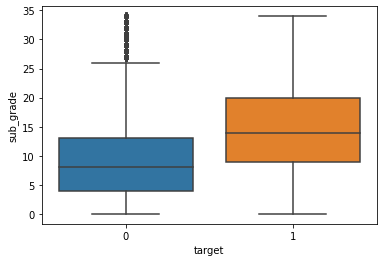

In [289]:
sns.boxplot(x='target', y='sub_grade', data=df)

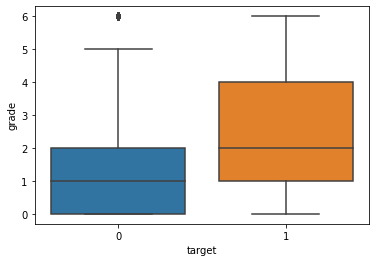

In [290]:
sns.boxplot(x='target', y='grade', data=df)

Both grade and sub_grade seem like promising predictors, since there seems to be a noticeable difference in the grades (lower grade/subgrade = better).

Nevertheless, it doesn't make sense to keep both, since grade and subgrade are dependent on one another (in the original data, if the Grade = A, then the Sub_Grade could ONLY be A1-A5).

Let's drop 'grade'. Sub_grade's extra values provide a bit more nuance.

In [297]:
df.drop(columns='grade', inplace=True)

In [153]:
#Employment status (using emp_title and emp_length)
pd.value_counts(df['emp_title'])

US Army                                                141
Bank of America                                        115
IBM                                                     73
AT&T                                                    65
Wells Fargo                                             61
                                                      ... 
Mudrush Technology Solutions                             1
Texas Departmenty of Family and Protective Services      1
coastal tec                                              1
Vintage Senior Living                                    1
Pacific Courier                                          1
Name: emp_title, Length: 30446, dtype: int64

There are 30446 different employment titles, none of which give a sense of employment stability. I think emp_length gives a better picture of employment stability, so emp_title will be dropped.

In [154]:
emp_len={'< 1 year':1,'1 year':2,'2 years':3,'3 years':4,'4 years':5,'5 years':6,
         '6 years':7,'7 years':8,'8 years':9,'9 years':10,'10+ years':11}
df.emp_length.replace(emp_len,inplace=True)
df.emp_length=df.emp_length.replace(np.nan,0)

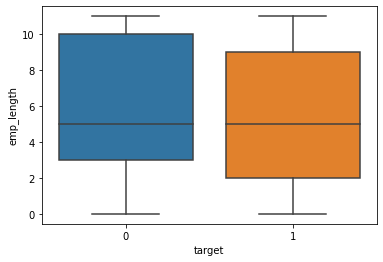

In [299]:
sns.boxplot(x='target',y='emp_length',data=df)

emp_length does not seem too promising as a predictor. It may be dropped in feature selection.

In [ ]:
Int_rate

In [155]:
df.int_rate = df.int_rate.str.replace(r'%','')
df.int_rate = df.int_rate.astype(float)
df.int_rate /= 100 #convert to decimal

pymnt_plan

In [156]:
pd.value_counts(df.pymnt_plan).to_frame()

,pymnt_plan
n,42535


pymnt_plan is supposed to be an indicator of whether a payment plan was made. However, 99.99% of the values are all the same. I'm not sure if this is informative. I will remove pymnt_plan

In [157]:
df.drop(columns='pymnt_plan', inplace=True)

home_ownership

In [158]:
pd.value_counts(df['home_ownership'])

RENT        20181
MORTGAGE    18959
OWN          3251
OTHER         136
NONE            8
Name: home_ownership, dtype: int64

home_ownership seems pretty informative. The values make intuitive sense, as well as the frequencies of each Home Ownership status

<b>desc</b>

desc is way too variable and wordy. There won't be anything meaningful unless we do extensive NLP. desc will be dropped.

In [159]:
pd.value_counts(df['purpose'])

debt_consolidation    19776
credit_card            5477
other                  4425
home_improvement       3199
major_purchase         2311
small_business         1992
car                    1615
wedding                1004
medical                 753
moving                  629
house                   426
educational             422
vacation                400
renewable_energy        106
Name: purpose, dtype: int64

keeping purpose

In [160]:
pd.value_counts(df['verification_status'])

Not Verified       18758
Verified           13471
Source Verified    10306
Name: verification_status, dtype: int64

keeping verification status

In [161]:
pd.value_counts(df['title'])

Debt Consolidation                           2332
Debt Consolidation Loan                      1772
Personal Loan                                 726
Consolidation                                 566
debt consolidation                            555
                                             ... 
Front Yard Lanscaping                           1
Paying Down Credit Card Debt                    1
Debt payoff loan                                1
Pay off debt, purchase used car                 1
Just need to pay off bills in one payment       1
Name: title, Length: 20958, dtype: int64

There are almost 21K unique 'title' values, which do not follow any sort of pattern. 'title' will be dropped.

In [162]:
pd.value_counts(df['application_type'])

Individual    42535
Name: application_type, dtype: int64

application_type has only 1 value, so it will be dropped.

In [163]:
df.revol_util = df.revol_util.str.replace(r'%','')
df.revol_util = df.revol_util.astype(float)
df.revol_util /= 100 #convert to decimal

In [164]:
pd.value_counts(df['initial_list_status'])

f    42535
Name: initial_list_status, dtype: int64

initial_list_status has only one value. Will be dropped.

In [165]:
pd.value_counts(df['hardship_flag'])

N    42535
Name: hardship_flag, dtype: int64

'hardship_flag' will be dropped; very small number of non-'N's

In [166]:
pd.value_counts(df['debt_settlement_flag'])

N    42375
Y      160
Name: debt_settlement_flag, dtype: int64

In [167]:
pd.value_counts(df.loc[df['debt_settlement_flag'] == 'N', 'loan_status'])

Fully Paid                                             34116
Charged Off                                             5520
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      751
Name: loan_status, dtype: int64

In [168]:
pd.value_counts(df.loc[df['debt_settlement_flag'] == 'Y', 'loan_status'])

Charged Off                                            150
Does not meet the credit policy. Status:Charged Off     10
Name: loan_status, dtype: int64

Even though there's a large imbalance in 'debt_settlement_flag', it appears in both types of loan_statuses. 'debt_settlement_flag' will be kept and transformed into a binary variable.

In [169]:
len(df[pd.isnull(df['debt_settlement_flag'])]) #counting the NaN's in debt_settlement_flag

4

It's a small number. Let's assume that NaN 'debt_settlement_flag' is equivalent to 'N' -- i.e. they did NOT seek a debt settlement company's help.

In [170]:
debt_settlement = {'N': 0, 'Y': 1}
df['debt_settlement_flag'].replace(debt_settlement, inplace=True)
df['debt_settlement_flag'].replace(np.nan, inplace=True)

### Dropping Categorical Variables <a class="anchor" id="section_1_3_1"></a>

Here we drop the categorical variables, as described above

In [176]:
df.drop(['desc','loan_status', 'title','emp_title', 
         'application_type','hardship_flag', 'initial_list_status'],axis=1,inplace=True)

## Transforming & Inspecting Numerical Features <a class="anchor" id="section_1_4"></a>

### Variables that may cause leakage <a class="anchor" id="section_1_4_1"></a>

Upon reading some of the features' descriptions, some of them may be causing target leakage, telling the training data the target variable. Specifically:

* collection_recovery_fee
* recoveries
* total_rec_prncp
* total_pymnt
* total_pymnt_inv

Let's first tackle these variables. 'recoveries' and 'collection_recovery_fee' are amounts that are recovered post-charge-off, which equate to a "bad" target variable or loan status, especially if the value > 0 dollars.

Furthermore, any feature that captures a total payment received is VERY likely to be leaking data; we can definitely expect "Fully Paid" loans to have a higher total_pymnt.

Let's see if values in these variables (that are > 0) are present in both classes. If they're present in the positive class (target = 1, or "bad" loan status), then that indicates target leakage.

These variables seem to be telling the same information. We will drop one of them in the end, if they are both valid (i.e. both are not target leakage sources).

In [181]:
pd.value_counts(df.loc[df['recoveries'] > 0, 'target']).to_frame()

,target
1,6359


In [184]:
pd.value_counts(df.loc[df['recoveries'] == 0, 'target']).to_frame()

,target
0,34116
1,2060


In [185]:
pd.value_counts(df.loc[df['collection_recovery_fee'] > 0, 'target']).to_frame()

,target
1,4329


In [187]:
pd.value_counts(df.loc[df['collection_recovery_fee'] == 0, 'target']).to_frame()

,target
0,34116
1,4090


Both variables, when their values > 0, were only populated for the positive class. This will lead to a deceptively optimistic model. This makes sense, since this variable would come AFTER a loan was charged off.

Because of the target leakage, these variables will be dropped.

In [ ]:
df.drop(['collection_recovery_fee', 'recoveries'], axis=1, inplace=True)

In [389]:
df.drop(columns='total_rec_prncp', inplace=True)

In [399]:
df.drop(columns=['total_pymnt', 'total_pymnt_inv'], inplace=True)

### 'Months Since' Variables <a class="anchor" id="section_1_4_2"></a>

These variables record a time since an event happened:
* mths_since_last_delinq

If these have NaN's, that implies that inquiries/delinquencies/collections have not happened. We cannot convert NaN's to 0, since that implies a very recent event (in this case, delinquency).

Let's change 'mths_since_last_delinq' to a binary variable if there are enough NaNs. This new variable will indicate whether that person has had a delinquency, rather than time since last delinquency.

In [204]:
df['mths_since_last_delinq'].unique() #checking to see if NaNs exist

array([ nan,  35.,  38.,  61.,   8.,  20.,  18.,  68.,  45.,  48.,  41.,
        40.,  74.,  25.,  53.,  39.,  10.,  26.,  56.,  77.,  28.,  52.,
        24.,  16.,  60.,  54.,  23.,   9.,  11.,  13.,  65.,  19.,  80.,
        22.,  59.,  79.,  44.,  64.,  57.,  14.,  63.,  49.,  15.,  73.,
        70.,  29.,  51.,   5.,  75.,  55.,   2.,  30.,  47.,  33.,  69.,
         4.,  43.,  21.,  27.,  46.,  81.,  78.,  82.,  31.,  76.,  62.,
        72.,  42.,  50.,   3.,  12.,  67.,  36.,  34.,  58.,  17.,  71.,
        66.,  32.,   6.,  37.,   7.,   1.,  83.,  86., 115.,  96., 103.,
       120., 106.,  89., 107.,  85.,  97.,  95.,   0.])

In [205]:
len(df[pd.isnull(df['mths_since_last_delinq'])]) #How many NaNs?

26930

In [207]:
#changing to binary and removing original variable
df.loc[(df.mths_since_last_delinq.notnull()),'delinq'] = 1
df.loc[(df.mths_since_last_delinq.isnull()),'delinq'] = 0
df.drop(columns='mths_since_last_delinq', inplace=True)

In [208]:
df.select_dtypes(include=['float', 'int']).columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths',
       'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens',
       'debt_settlement_flag', 'target', 'delinq'],
      dtype='object')

In [216]:
df.select_dtypes(include=['float', 'int']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42539 entries, 0 to 42538
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   42535 non-null  float64
 1   funded_amnt                 42535 non-null  float64
 2   funded_amnt_inv             42535 non-null  float64
 3   term                        42535 non-null  float64
 4   int_rate                    42535 non-null  float64
 5   installment                 42535 non-null  float64
 6   grade                       42535 non-null  float64
 7   sub_grade                   42535 non-null  float64
 8   emp_length                  42539 non-null  float64
 9   annual_inc                  42531 non-null  float64
 10  dti                         42535 non-null  float64
 11  delinq_2yrs                 42506 non-null  float64
 12  inq_last_6mths              42506 non-null  float64
 13  open_acc                    425

In [214]:
df.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42539 entries, 0 to 42538
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   home_ownership       42535 non-null  object
 1   verification_status  42535 non-null  object
 2   purpose              42535 non-null  object
 3   addr_state           42535 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


# ASIDE: Null rows <a class="anchor" id="section_1_4_3"></a>

At this point, I am noticing that most variables have 4 NaN values. Are they the same rows?

In [219]:
df[df.isnull().any(axis=1)]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,debt_settlement_flag,target,delinq
26,15000.0,15000.0,8725.0,36.0,0.1427,514.64,2.0,11.0,10.0,RENT,60000.0,Not Verified,2020-12-11,debt_consolidation,NY,15.22,0.0,2020-10-03,1.0,7.0,0.0,5872.0,0.576,11.0,0.0,0.0,0.00000,0.00,0.0,0.00,0.0,NaT,0.00,2020-02-19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2731,8000.0,8000.0,3975.0,36.0,0.1465,275.96,2.0,12.0,11.0,RENT,72000.0,Source Verified,2020-11-11,debt_consolidation,NC,22.28,0.0,1997-11-01,1.0,10.0,0.0,32955.0,0.858,31.0,0.0,0.0,0.00000,0.00,0.0,0.00,0.0,NaT,0.00,2020-07-19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
3577,8000.0,8000.0,8000.0,36.0,0.1942,294.95,4.0,22.0,4.0,RENT,30000.0,Source Verified,2020-11-11,debt_consolidation,IL,18.56,0.0,1992-09-01,1.0,6.0,0.0,0.0,NaN,10.0,0.0,0.0,10706.01082,10706.01,8000.0,2691.01,15.0,2020-12-14,76.83,2020-07-19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3625,6400.0,6400.0,6400.0,60.0,0.1825,163.39,3.0,19.0,6.0,RENT,33000.0,Source Verified,2020-11-11,major_purchase,OH,9.05,0.0,2020-06-06,3.0,4.0,0.0,2237.0,0.605,6.0,0.0,0.0,366.75000,366.75,0.0,0.00,0.0,NaT,0.00,2020-10-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
3998,18000.0,18000.0,18000.0,60.0,0.1903,467.23,4.0,21.0,5.0,RENT,36000.0,Verified,2020-11-11,debt_consolidation,CT,5.43,0.0,2020-08-08,1.0,13.0,0.0,4545.0,0.186,17.0,0.0,0.0,0.00000,0.00,0.0,0.00,0.0,NaT,0.00,2020-12-18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42534,5000.0,5000.0,0.0,36.0,0.0775,156.11,0.0,2.0,11.0,MORTGAGE,70000.0,Not Verified,2020-06-07,other,CT,8.81,NaN,NaT,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,5619.76209,0.00,5000.0,619.76,0.0,2020-06-10,156.39,2020-02-15,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0
42535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0
42536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0
42537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0


Yes; the last 4 rows are unpopulated rows. Let's get rid of them.

In [223]:
df.drop(df.tail(4).index,inplace=True)

### Numerical Indicators and Codes <a class="anchor" id="section_1_4_4"></a>

These numerical variables act as codes:
* policy_code

Let's change them to binary variables, assuming it's a good variable

In [228]:
pd.value_counts(df['policy_code'])

1.0    42535
Name: policy_code, dtype: int64

Not a good variable. Only 1 value. Let's drop it.

In [229]:
df.drop(columns='policy_code', inplace=True)

## Transforming & Inspecting Date Features <a class="anchor" id="section_1_5"></a>

In [239]:
df.select_dtypes(include=['datetime']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42534
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   issue_d             42535 non-null  datetime64[ns]
 1   earliest_cr_line    42506 non-null  datetime64[ns]
 2   last_pymnt_d        42452 non-null  datetime64[ns]
 3   last_credit_pull_d  42531 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.6 MB


Usually, date features would be manipulated to calculate time duration.

However, this only works if there is a consistent analysis date as reference for each date field. Since there is no information about which date to use as reference, we will simply drop the date columns.

In [240]:
df.drop(columns = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'], inplace=True)

## Missing Values <a class="anchor" id="section_1_6"></a>

Now let's see how to deal with the remaining variables with missing values. What replacement values make sense for these fields? Or, more importantly, what are sensible assumptions for each field whenever they have missing values?

In [241]:
#The columns with missing values
missing_cols = df.columns[df.isnull().any()].to_list()
missing_cols

['annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

In [242]:
#How many missing values do these columns have?
for col in missing_cols:
    print('{} -------- {}'.format(df[col].isna().sum(), col))

4 -------- annual_inc
29 -------- delinq_2yrs
29 -------- inq_last_6mths
29 -------- open_acc
29 -------- pub_rec
90 -------- revol_util
29 -------- total_acc
145 -------- collections_12_mths_ex_med
29 -------- acc_now_delinq
145 -------- chargeoff_within_12_mths
29 -------- delinq_amnt
1365 -------- pub_rec_bankruptcies
105 -------- tax_liens


### Missing Values -> 0 <a class="anchor" id="section_1_6_1"></a>

For these fields, it makes sense to assume that a missing value means an absence, or a value of 0:

* delinq_2yrs (may drop or change to binary, since delinquency is captured by 'acc_now_delinq')
* inq_last_6mths
* open_acc
* pub_rec
* total_acc
* collections_12_mths_ex_med
* acc_now_delinq (may change to binary, depending on distribution)
* chargeoff_within_12_mths
* delinq_amnt (actually a redundant variable, since 'acc_now_delinq' and 'delinq_2yrs' captures delinquency)
* pub_rec_bankruptcies
* tax_liens

The first step will be to replace all NaNs with 0s for these fields. After that

In [251]:
missing_cols_1 = ['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc',
                 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths',
                 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens']

df[missing_cols_1] = df[missing_cols_1].fillna(0)

In [261]:
pd.value_counts(df['acc_now_delinq'])

0.0    42531
1.0        4
Name: acc_now_delinq, dtype: int64

In [263]:
pd.value_counts(df['delinq_amnt'])

0.0       42533
6053.0        1
27.0          1
Name: delinq_amnt, dtype: int64

In [276]:
pd.value_counts(df['delinq_2yrs'])

0.0     37800
1.0      3595
2.0       771
3.0       244
4.0        72
5.0        27
6.0        13
7.0         6
8.0         3
11.0        2
13.0        1
9.0         1
Name: delinq_2yrs, dtype: int64

The 3 delinquency features with parentheticals above had to be inspected separately. It seems that only 1 of them contains useful information: 'delinq_2yrs', which tells us how many delinquencies a person has in the past 2 years.

The other 2 delinquency features have the same value for all except a (single-digit) handful of rows. So let's drop those 2

In [277]:
df.drop(columns=['acc_now_delinq', 'delinq_amnt'], inplace=True)

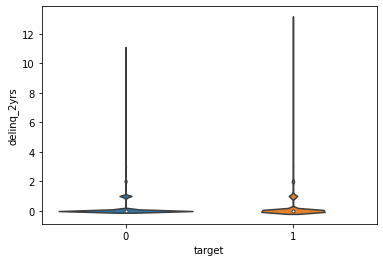

In [275]:
p = sns.violinplot(x='target', y='delinq_2yrs', data=df)

In [267]:
pd.value_counts(df['delinq_2yrs'])

0.0     37800
1.0      3595
2.0       771
3.0       244
4.0        72
5.0        27
6.0        13
7.0         6
8.0         3
11.0        2
13.0        1
9.0         1
Name: delinq_2yrs, dtype: int64

### Missing Vales -> mode <a class="anchor" id="section_1_6_2"></a>

For the remaining 2 features with missing values ('annual_inc', 'revol_util'), it doesn't make sense to replace the missing values with 0.

'annual_inc' only has 4 missing values, so I feel comfortable replacing it with the most commonly occuring value.

'revol_util' needs a bit more inspection, since it has 90 missing values. Before I replace missing values with its mode or mean or median, let's check to see if the missing values aren't exclusively in the positive target class. Are the missing values systematically appearing in the target = 1 class?

In [278]:
df['annual_inc']=df['annual_inc'].replace(np.nan,df['annual_inc'].mode()[0])

In [285]:
len(df[(df['target'] == 1) & (np.isnan(df['revol_util']))])

56

'revol_util' is not completely in the positive class, so we can impute missing values. Because of the distribution of its values, let's use mode or median (both will achieve the same outcome)

In [286]:
df['revol_util']=df['revol_util'].replace(np.nan,df['revol_util'].mode()[0])

## Encoding Categorical Variables <a class="anchor" id="section_1_7"></a>

The last thing we want to do before building our XGBoost model is to dummy code our remaining categorical variables.

In [301]:
#Get the list of categorical vars
cat_cols = df.select_dtypes(include=['object']).columns.to_list()
cat_cols

['home_ownership', 'verification_status', 'purpose', 'addr_state']

In [400]:
#Dummy code
df_final= pd.get_dummies(df, columns=cat_cols, prefix=cat_cols)

# Modeling <a class="anchor" id="modeling"></a>

In [411]:
import xgboost
import random
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc,roc_auc_score,roc_curve, recall_score,classification_report,accuracy_score
from sklearn.feature_selection import SelectFromModel

## Train/Test Splits <a class="anchor" id="section_2_1"></a>

In [401]:
X = df_final.loc[:, df_final.columns != 'target']
y = df_final.loc[:, df_final.columns == 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Feature Selection -- using Feature Importance, Trial 1 <a class="anchor" id="section_2_2"></a>

Even though XGBoost can handle large amounts of features, does including all of them lead to a more accurate model?

Let's get a baseline accuracy using all features

In [402]:
random.seed(7)

# Handles class imbalance, to be used for 'scale_pos_weight' arg when building XGBClassifier()
class_weight = len(df_final[df_final.target == 0])/len(df_final[df_final.target == 1])

model = xgboost.XGBClassifier(scale_pos_weight = class_weight)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.81%


Really good! But let's check the feature importances

In [403]:
#How many features have an importance of 0?

len(model.feature_importances_[model.feature_importances_ == 0])

29

There are 29 features with a feature importance of 0 in this run of XGBoost.

In [404]:
sorted_idx = model.feature_importances_.argsort() #get indices of feature importances, sorted in ascending order
df_final.columns[sorted_idx][:29] #print the features that have 0 importance (there are 37 of them)

Index(['purpose_debt_consolidation', 'tax_liens', 'home_ownership_MORTGAGE',
       'purpose_major_purchase', 'purpose_other', 'addr_state_NJ',
       'addr_state_WI', 'addr_state_AR', 'addr_state_CA',
       'chargeoff_within_12_mths', 'addr_state_DC', 'addr_state_HI',
       'addr_state_IA', 'addr_state_IL', 'addr_state_KY', 'addr_state_MD',
       'addr_state_MN', 'addr_state_MO', 'addr_state_MS', 'addr_state_GA',
       'collections_12_mths_ex_med', 'addr_state_NC', 'addr_state_OK',
       'addr_state_VA', 'addr_state_SD', 'out_prncp_inv', 'addr_state_PA',
       'addr_state_SC', 'out_prncp'],
      dtype='object')

It seems like a lot of the non-important features pertain to the different states.

What are the MOST important features?

Text(0.5, 0, 'Xgboost Feature Importance')

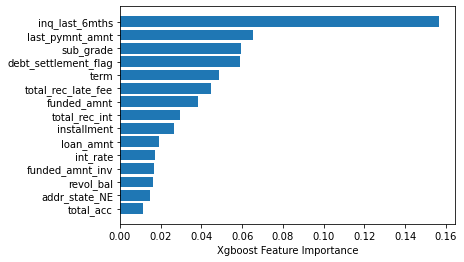

In [423]:
#Plotting the 15 most important features from XGB model
plt.barh(df_final.columns[sorted_idx][-15:], model.feature_importances_[sorted_idx][-15:])
plt.xlabel("Xgboost Feature Importance")

Let's put this thought to the test: do we really need all 100 features to get the best model?

We'll do this by taking all unique the feature importance values, and using 'SelectFromModel' with each threshold being each unique feature importance value, and recording which features (and how many) correspond to the one with the highest accuracy and ROC AUC.

**Note: we use Accuracy and ROC AUC as metrics to compare the different XGBoost models, simply due to lack of domain knowledge. Class imbalance is taken care of using the 'scale_pos_weight' parameter, with the class weights calculated as # negative / # positive.**

**Ideally, we would use a GridSearchCV to iterate through different class weights, but time and PC constraints limit this. For now, let's just go with the recommended # negative / # positive weights, which gives the ratio of Negative-to-Positive class members (roughly 4:1)**

**While it is very important to correctly flag the positive class, and while there are costs for False Negatives, I will make the assumption that False Positives are also somewhat costly, since I imagine that an overly-stringent system of loan approvals will deter potential applicants from applying and thus slow down revenue.**

In [429]:
class_weight

4.052262739042642

In [415]:
#Record results
thresholds = np.unique(np.sort(model.feature_importances_))
accuracies = []
aucs = []
fprs = None
tprs = None
num_features = []
best_accuracy = 0
best_auc = 0
best_num_features_acc = 0
best_num_features_auc = 0

In [372]:
import warnings
warnings.filterwarnings('ignore')

In [416]:
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgboost.XGBClassifier(scale_pos_weight = class_weight)
    selection_model.fit(select_X_train, y_train)
    # eval model - accuracy
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    # eval model - ROC AUC
    accuracy = accuracy_score(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test,predictions)
    roc_auc = auc(fpr, tpr)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    
    # Record results for plotting at the end
    accuracies.append(accuracy)
    aucs.append(roc_auc)
    num_features.append(select_X_train.shape[1])
    selected_features = selection_model.get_booster().feature_names
    
    # Record best results for plotting at the end
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_features_acc = len(selected_features)
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_num_features_auc = len(selected_features)
        fprs = fpr
        tprs = tpr

Thresh=0.000, n=100, Accuracy: 92.81%
Thresh=0.001, n=71, Accuracy: 92.81%
Thresh=0.002, n=70, Accuracy: 92.74%
Thresh=0.003, n=69, Accuracy: 92.56%
Thresh=0.004, n=68, Accuracy: 92.79%
Thresh=0.004, n=67, Accuracy: 92.95%
Thresh=0.004, n=66, Accuracy: 92.65%
Thresh=0.004, n=65, Accuracy: 92.82%
Thresh=0.005, n=64, Accuracy: 92.81%
Thresh=0.005, n=63, Accuracy: 92.49%
Thresh=0.005, n=62, Accuracy: 92.74%
Thresh=0.005, n=61, Accuracy: 92.48%
Thresh=0.005, n=60, Accuracy: 92.68%
Thresh=0.005, n=59, Accuracy: 92.56%
Thresh=0.005, n=58, Accuracy: 93.03%
Thresh=0.005, n=57, Accuracy: 92.79%
Thresh=0.005, n=56, Accuracy: 92.88%
Thresh=0.005, n=55, Accuracy: 92.94%
Thresh=0.006, n=54, Accuracy: 92.89%
Thresh=0.006, n=53, Accuracy: 92.76%
Thresh=0.006, n=52, Accuracy: 92.78%
Thresh=0.006, n=51, Accuracy: 92.49%
Thresh=0.006, n=50, Accuracy: 92.62%
Thresh=0.006, n=49, Accuracy: 92.74%
Thresh=0.006, n=48, Accuracy: 92.77%
Thresh=0.006, n=47, Accuracy: 92.76%
Thresh=0.006, n=46, Accuracy: 92.96%


Text(0.5, 1.0, 'Num. Features vs. Accuracies')

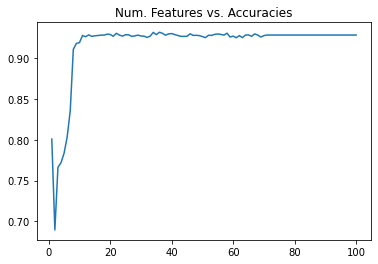

In [417]:
sns.lineplot(x=num_features, y=accuracies).set_title('Num. Features vs. Accuracies')

Text(0.5, 1.0, 'Num. Features vs. ROC AUCs')

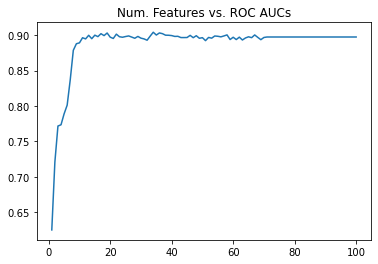

In [418]:
sns.lineplot(x=num_features, y=aucs).set_title('Num. Features vs. ROC AUCs')

## Conclusion: all variables are not needed.

Both accuracy and ROC AUC taper off when n=10, or when 10 features (added in order of decreasing importance, starting with the most important) are included. Furthermore, by eyeballing the print-out accuracies, it seems that less features even leads to a slightly BETTER performance than the entire feature space.

## Model Evaluation <a class="anchor" id="section_2_3"></a>



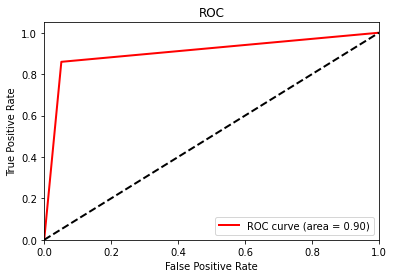

In [419]:
plt.figure()
lw=2
plt.plot(fprs, tprs, color='red', lw=lw, label='ROC curve (area = %0.2f)' % best_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [421]:
print('Best accuracy: {}\nSelected Features:{}'.format(best_accuracy, best_num_features_acc))

Best accuracy: 0.9314682026566357
Selected Features:36


In [422]:
print('Best ROC AUC: {}\nSelected Features:{}'.format(best_auc, best_num_features_auc))

Best ROC AUC: 0.9041213690440772
Selected Features:34


In [435]:
print('Accuracy of 34-feature model: {}'.format(accuracies[-34]))

Accuracy of 34-feature model: 0.9312331021511696


In [437]:
print('AUC of 36-feature model: {}'.format(aucs[-36]))

AUC of 36-feature model: 0.9031382239598464


In [428]:
# So...what ARE these 34/36 variables??
# Sorted from most important to least important
df_final.columns[sorted_idx][-36:].to_list()[::-1]

['inq_last_6mths',
 'last_pymnt_amnt',
 'sub_grade',
 'debt_settlement_flag',
 'term',
 'total_rec_late_fee',
 'funded_amnt',
 'total_rec_int',
 'installment',
 'loan_amnt',
 'int_rate',
 'funded_amnt_inv',
 'revol_bal',
 'addr_state_NE',
 'total_acc',
 'pub_rec',
 'purpose_renewable_energy',
 'addr_state_AL',
 'annual_inc',
 'addr_state_VT',
 'purpose_vacation',
 'addr_state_OR',
 'addr_state_FL',
 'home_ownership_NONE',
 'home_ownership_RENT',
 'addr_state_MA',
 'addr_state_WA',
 'addr_state_LA',
 'purpose_educational',
 'revol_util',
 'pub_rec_bankruptcies',
 'addr_state_OH',
 'addr_state_NM',
 'purpose_car',
 'open_acc',
 'addr_state_DE']

It looks like the accuracy spikes WAAAY up after adding the 2nd most important feature (**total_rec_prncp**), which is the total received principal payment, to date. This would make sense as to why adding this feature would spike the accuracy way up; loans that are unable to be paid off will OF COURSE have lower total payments.

Looking at the 34-36 most important features, the resulting features seem to make sense.

Even though the 34-feature model resulted in the highest AUC ROC, and the 36-feature model resulted in the highest accuracy, the differences are very small, and the differences are unlikely to make a real-world impact. In that case, I would stick to the 34-feature model due to model simplicity.

Text(0.5, 0, 'Xgboost Feature Importance - Top Variables from Best Model')

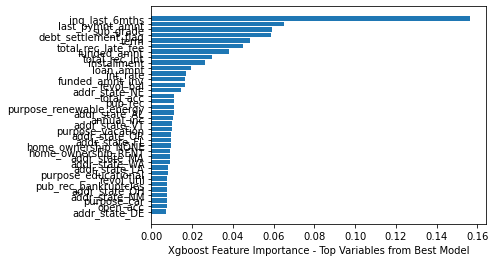

In [434]:
plt.barh(df_final.columns[sorted_idx][-36:], model.feature_importances_[sorted_idx][-36:])
plt.xlabel("Xgboost Feature Importance - Top Variables from Best Model")

# Summary <a class="anchor" id="summary"></a>

After extensive inspection, EDA, transformation, and reduction of our data into a model-friendly format (taking care of missing values, encoding categorical variables, removing features that leak), we have found a reduced model that gives the best accuracy and the best ROC AUC.

The final XGBoost model and its performance are summarized below:

* Features: 34
* Final Accuracy: 0.931
* Final ROC AUC: 0.903